In [1]:
import LR_model

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score

In [3]:
train_df = pd.read_csv("./train.csv")
train_df = train_df.drop(["PassengerId", "Name", "Ticket"], axis = 1)
train_df = train_df.dropna()

In [4]:
oh = OneHotEncoder(sparse_output=False, drop='first')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [5]:
train_df[["Cabin"]] = oe.fit_transform(train_df[["Cabin"]])
encoded_data = oh.fit_transform(train_df[["Sex", "Embarked"]])
feature_names = oh.get_feature_names_out(["Sex", "Embarked"])
encoded_df = pd.DataFrame(encoded_data, columns=feature_names, index=train_df.index)
train_df = pd.concat([train_df, encoded_df], axis=1)
train_df = train_df.drop(["Sex", "Embarked"], axis = 1)

In [6]:
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_male,Embarked_Q,Embarked_S
1,1,1,38.0,1,0,71.2833,72.0,0.0,0.0,0.0
3,1,1,35.0,1,0,53.1000,48.0,0.0,0.0,1.0
6,0,1,54.0,0,0,51.8625,117.0,1.0,0.0,1.0
10,1,3,4.0,1,1,16.7000,131.0,0.0,0.0,1.0
11,1,1,58.0,0,0,26.5500,43.0,0.0,0.0,1.0


In [7]:
y = train_df["Survived"]
X = train_df.drop(["Survived"], axis = 1)

se = StandardScaler()
se.fit(X)

X = se.transform(X)

In [23]:
def cv_(lr, X ,y, n, states, custom):
    acc, prec, rec, probs, all_weights = [], [], [], [], []
    
    for k in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=states[k])
                
        lr.fit(X_train, y_train)
        
        preds = lr.predict(X_test)
        if(custom):
            all_weights.append(lr.get_weigths())
            proba = [g.probability for g in preds]
            preds = [p.prediction for p in preds]
        else:
            all_weights.append(np.append(lr.coef_[0], lr.intercept_[0]).tolist())
            proba = lr.predict_proba(X_test)[:, 1]

        acc.append(accuracy_score(y_test, preds))
        prec.append(precision_score(y_test, preds))
        rec.append(recall_score(y_test, preds))
        
        probs.append(proba)

    return [acc, prec, rec, probs, all_weights]

In [24]:
lr = LR_model.LogisticRegression(1000, "lbfgs", 2.0, 0, 200, 1e-7)
lr_gradient = LR_model.LogisticRegression(100000, "gradientdescent", 1.0, 0.05, 0, 1e-4)
lr_sklearn = LogisticRegression(max_iter=1000, solver="lbfgs", tol=1e-7)

In [37]:
n = 5
states = list(range(1,n + 1))
lr_score = cv_( lr, X.tolist(), y.astype(bool).tolist(), n, states, True)
lr_gradient_score = cv_( lr_gradient, X.tolist(), y.astype(bool).tolist(), n, states, True)
lr_sklearn_score = cv_(lr_sklearn, X, y, n, states, False)

print(f"Accuracy:\n LBFGS: {np.mean(lr_score[0])} ; GradientDescent: {np.mean(lr_gradient_score[0])} ; Sklearn-LBFGS: {np.mean(lr_sklearn_score[0])}")
print(f"Precision:\n LBFGS: {np.mean(lr_score[1])} ; GradientDescent: {np.mean(lr_gradient_score[1])} ; Sklearn-LBFGS: {np.mean(lr_sklearn_score[1])}")
print(f"Recall:\n LBFGS: {np.mean(lr_score[2])} ; GradientDescent: {np.mean(lr_gradient_score[2])} ; Sklearn-LBFGS: {np.mean(lr_sklearn_score[2])}")

Accuracy:
 LBFGS: 0.7239130434782609 ; GradientDescent: 0.7086956521739131 ; Sklearn-LBFGS: 0.6978260869565218
Precision:
 LBFGS: 0.7867334915017213 ; GradientDescent: 0.7739783758510855 ; Sklearn-LBFGS: 0.7605271983809012
Recall:
 LBFGS: 0.7910491564263669 ; GradientDescent: 0.7811566833080874 ; Sklearn-LBFGS: 0.7877158230930336


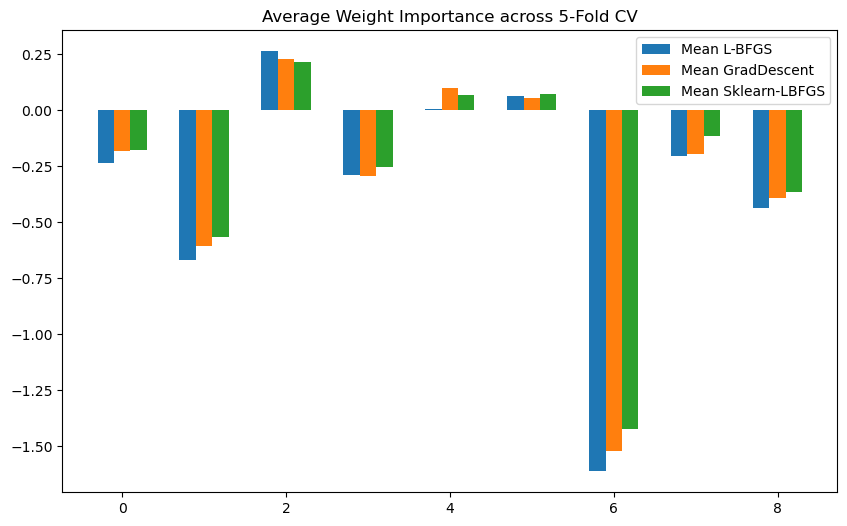

In [38]:
mean_lbfgs_weights = np.mean(lr_score[4], axis=0)[:-1]
mean_grad_weights = np.mean(lr_gradient_score[4], axis=0)[:-1]
mean_sklearn_weights = np.mean(lr_sklearn_score[4], axis=0)[:-1]

plt.figure(figsize=(10, 6))
x_axis = np.arange(len(features))

plt.bar(x_axis - 0.2, mean_lbfgs_weights, 0.2, label='Mean L-BFGS')
plt.bar(x_axis, mean_grad_weights, 0.2, label='Mean GradDescent')
plt.bar(x_axis + 0.2, mean_sklearn_weights, 0.2, label='Mean Sklearn-LBFGS')

plt.title(f"Average Weight Importance across {n}-Fold CV")
plt.legend()
plt.show()

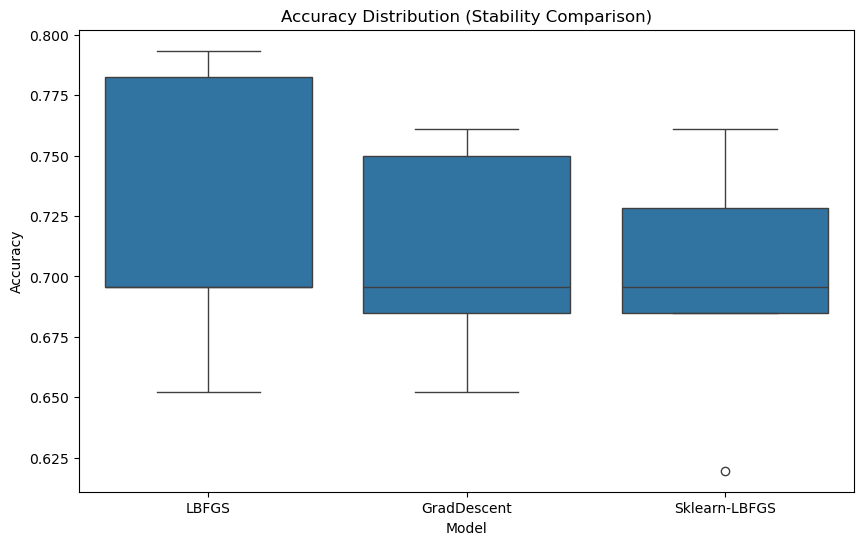

In [39]:
data = {
    'Accuracy': lr_score[0] + lr_gradient_score[0] + lr_sklearn_score[0],
    'Model': ['LBFGS']*n + ['GradDescent']*n + ['Sklearn-LBFGS']*n
}

df_results = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Accuracy', data=df_results)
plt.title('Accuracy Distribution (Stability Comparison)')
plt.show()